# R-Excel - Excel automation with YT comments
   
<i> Antoni Perużyński</i> 

## Aim of project

The main purpose of the project is create app which for url from video on yt can get comments from this video. Next find top 10 tokens and create a graph. The last part is save it to xlsx file using xlwings.

## Imports

In [6]:
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request

import urllib.parse as p
import re
import os
import pickle

# import nltk
# #nltk.download('stopwords')
# #nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

import re

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set_theme()
from tabulate import tabulate
from PIL import Image

import sklearn as sk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import xlwings as xw


## Functions

In [7]:
def Top10_OneSet(sample, tit, jpg_name, video_id, channel_ID):
    #-----------------------------------------------------------
    # Get top 10 tokens
    vectorizer = CountVectorizer(tokenizer=text_tokenizer)
    X_transform_sample = vectorizer.fit_transform(sample)

    titles = (vectorizer.get_feature_names_out ())  
    array = X_transform_sample.toarray()

 
    print("Display top 10 tokens")
    column_sum = np.sum(array, axis=0)  
    max_val_col = np.argpartition(column_sum, -10)[-10:]  
    top_10_quantity = column_sum[max_val_col]
    
  
    top_10_tokens = []
    for i in max_val_col:
        top_10_tokens.append(titles[i])
 
    print(top_10_tokens)

    # Set the facecolor for all figures
    plt.rcParams["figure.facecolor"] = "black"
    plt.rcParams['axes.labelcolor'] = "white"
    plt.rcParams['xtick.color'] = "white"
    plt.rcParams['ytick.color'] = "white"
    plt.rcParams['axes.titlecolor'] = "white"
    
    df_1 = pd.DataFrame({'tokens': top_10_tokens, 'quantity': top_10_quantity})
    df_1 = df_1.sort_values(by = "quantity")
    plot = df_1.plot(kind = 'barh', x = 'tokens', y = 'quantity', color = 'RoyalBlue',
                     title = tit)
    fig = plot.get_figure()
    fig
    #fig.savefig(jpg_name+'.png')
    df_1 = df_1.sort_values(by = "quantity", ascending = False)
    plt.show()
    print(tabulate(df_1, headers='keys', tablefmt='psql')) 
    #-----------------------------------------------------------
    
    video_stats_dict = get_video_details(youtube, [video_id])

    df_stats_video = pd.DataFrame.from_dict(video_stats_dict[0], orient='index', columns =["Film"])
    
    #-----------------------------------------------------------
    # Getting info about channel
    response = get_channel_details(youtube, id=channel_ID)
    # extract channel infos

    snippet = response["items"][0]["snippet"]
    statistics = response["items"][0]["statistics"]
    channel_country = snippet["country"]
    channel_description = snippet["description"]
    channel_creation_date = snippet["publishedAt"]
    channel_title = snippet["title"]
    channel_subscriber_count = statistics["subscriberCount"]
    channel_video_count = statistics["videoCount"]
    channel_view_count  = statistics["viewCount"]
    
    df_channel_info = pd.DataFrame([channel_title, channel_creation_date, channel_description,
                                    channel_country, channel_video_count, channel_subscriber_count, channel_view_count],
                                   index = ["Title", "Published At","Description",
                                            "Country", "Number of videos", "Number of subscribers", "Total views"])
    #-----------------------------------------------------------
    
    #-----------------------------------------------------------
    #Saving do xlsx file -> Using XLWings
    wb = xw.Book()
    ws = wb.sheets[0]
    ws.pictures.add(fig, name='MyPlot', update=True, left=ws.range((1,5)).left, top=ws.range((15,5)).top)
    #ws["A1"].options(pd.DataFrame, header=1, index=True, expand='table').value = df_1
    #ws["D1"].options(pd.DataFrame, header=1, index=True, expand='table').value = df_stats_video
    ws.range((2,2)).options(pd.DataFrame, header=1, index=True, expand='table').value = df_channel_info
    ws.range((10,2)).options(pd.DataFrame, header=1, index=True, expand='table').value = df_stats_video
    ws.range((19,2)).options(pd.DataFrame, header=1, index=True, expand='table').value = df_1
    #wb.save()
    wb.save(r'C:\\Users\\DELL\\YT\\Youtuber_Top_10.xlsx')
    wb.close()
    #-----------------------------------------------------------
    
    return



def stopwords_function(text: str) -> str:

    stop_words = stopwords.words('english')
    #word_token = word_tokenize(text)
    cleaned = [w for w in text if w not in stop_words]
    return " ".join(cleaned)

def stemming_function(text: str) -> list:
    stemming = PorterStemmer()
    txt_list = list(text.split(" "))
    stemmed_txt = []
    for w in txt_list:
        stemmed_txt.append(stemming.stem(w))
    return stemmed_txt

def clean_text(txt: str) -> str:
    find_emoticons = re.findall(r"[:;][-]?[/\|\)\(><D]", txt)
    txt_low = txt.lower()
    delete_numbers = re.sub("[0-9]+", "", txt_low)
    delete_html = re.sub(r'<.*?>', '', delete_numbers)
    delete_punctuation = re.sub(r"[^\w\s]", " ", delete_html)
    delete_whitespace = delete_punctuation.strip()
    clean_txt = delete_whitespace + ' '.join(find_emoticons)
    return clean_txt

def text_tokenizer(text: str):

    cleaned_text = clean_text(text)
    tokens = word_tokenize(cleaned_text)
    without_stopwords =stopwords_function(tokens)
    stemmed_text = stemming_function(without_stopwords)

    return [w for w in stemmed_text if len(w) > 3]

def vectorizing(sample):
    vectorizer1 = CountVectorizer(tokenizer=text_tokenizer)
    X_transform_sample = vectorizer1.fit_transform(sample)
    titles_sample = (vectorizer1.get_feature_names_out())
    array = X_transform_sample.toarray()
    return array, titles_sample

def vectorizing_voc(sample, vocabulary):
    vectorizer1 = CountVectorizer(tokenizer=text_tokenizer, vocabulary=vocabulary)
    X_transform_sample = vectorizer1.fit_transform(sample)
    titles_sample = (vectorizer1.get_feature_names_out())
    array = X_transform_sample.toarray()
    return array, titles_sample

In [8]:
def get_channel_details(youtube, **kwargs):
    return youtube.channels().list(
        part="statistics,snippet,contentDetails",
        **kwargs
    ).execute()

def get_video_id_by_url(url):
    """
    Return the Video ID from the video `url`
    """
    # split URL parts
    parsed_url = p.urlparse(url)
    # get the video ID by parsing the query of the URL
    video_id = p.parse_qs(parsed_url.query).get("v")
    if video_id:
        return video_id[0]
    else:
        raise Exception(f"Wasn't able to parse video URL: {url}")
               
def get_video_details(youtube, video_ids):
    all_video_stats = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
                    part='snippet,statistics',
                    id=','.join(video_ids[i:i+50]))
        response = request.execute()
        
        for video in response['items']:
            video_stats = dict(Title = video['snippet']['title'],
                               Published_date = video['snippet']['publishedAt'],
                               Views = video['statistics']['viewCount'],
                               Likes = video['statistics']['likeCount'],
                               #Dislikes = video['statistics']['dislikeCount'],
                               Comments = video['statistics']['commentCount']
                               )
            all_video_stats.append(video_stats)
#             print(video['snippet'])
    
    return all_video_stats
        
def get_comments(youtube, **kwargs):
    return youtube.commentThreads().list(
        part="snippet",
        **kwargs
    ).execute()

def get_comment_list(film_url, channel_ID):
    # URL can be a channel or a video, to extract comments
    commentList=[]
    url = film_url
    if "watch" in url:
        # that's a video
        video_id = get_video_id_by_url(url)
        params = {
            'videoId': video_id, 
            'maxResults': 2,
            'order': 'relevance', # default is 'time' (newest)
        }
    else:
        # should be a channel
        channel_id = channel_ID #get_channel_id_by_url(url)
        params = {
            'allThreadsRelatedToChannelId': channel_id, 
            'maxResults': 2,
            'order': 'relevance', # default is 'time' (newest)
        }
    #print(video_id)
    # get the first 2 pages (2 API requests)
    n_pages = 500
    for i in range(n_pages):
        # make API call to get all comments from the channel (including posts & videos)
        response = get_comments(youtube, **params)
        items = response.get("items")
        # if items is empty, breakout of the loop
        if not items:
            break
        for item in items:
            comment = item["snippet"]["topLevelComment"]["snippet"]["textDisplay"]
            commentList.append(comment)
#             updated_at = item["snippet"]["topLevelComment"]["snippet"]["updatedAt"]
#             like_count = item["snippet"]["topLevelComment"]["snippet"]["likeCount"]
#             comment_id = item["snippet"]["topLevelComment"]["id"]
#             print(f"""\
#             Comment: {comment}
#             Likes: {like_count}
#             Updated At: {updated_at}
#             ==================================\
#             """)
        if "nextPageToken" in response:
            # if there is a next page
            # add next page token to the params we pass to the function
            params["pageToken"] =  response["nextPageToken"]
        else:
            # must be end of comments!!!!
            break
        #print("*"*70)
    return commentList, video_id

In [16]:
import requests
from bs4 import BeautifulSoup
def get_Channel_ID_from_url(URL):
    #URL = "https://www.youtube.com/watch?v=EOWP5Y7eErE"
    page = requests.get(URL)

    soup = BeautifulSoup(page.content, "html.parser")

    string_id = str(soup.find(class_ = 'watch-main-col').find_all('meta', itemprop = 'channelId'))

    def find(s, ch):
        return [i for i, ltr in enumerate(s) if ltr == ch]

    whereIsQuote = find(string_id, '\"')
    channelID = string_id[whereIsQuote[0]+1:whereIsQuote[1]]
    return channelID

## Main part of automatization

### Api_key and info about chanell

In [11]:
api_key = "YOUR API KEY"
youtube = build('youtube', 'v3', developerKey=api_key)

In [12]:
# 1 way
# channel_ids = ['UCFBH3Bdhgh3_cCToEQsUp6Q'] # Gimper]
# film_url = "https://www.youtube.com/watch?v=qXfnHBvFsyA"
# channel_ID = [0]

In [17]:
# 2 way
film_url = "https://www.youtube.com/watch?v=4OZip0cgOho"
channel_ID = get_Channel_ID_from_url(film_url)

In [19]:
commentList = []
commentList, video_id = get_comment_list(film_url, channel_ID)

In [10]:
df = pd.DataFrame(commentList, columns = ["comment"])
df

,comment
0,Thanks for watching everyone! Please leave som...
1,"<a href=""https://www.youtube.com/watch?v=4OZip..."
2,Hello! I am a complete beginner but one day I’...
3,Love this! As a pragmatist I find it appallin...
4,Best advice from a data scientist: 1) nothing ...
...,...
784,Do you have a hickey ?
785,Heyy
786,You still replying?
787,Kaggle


Display top 10 tokens
['would', 'want', 'like', 'python', 'start', 'learn', 'video', 'data', 'thank', 'scienc']


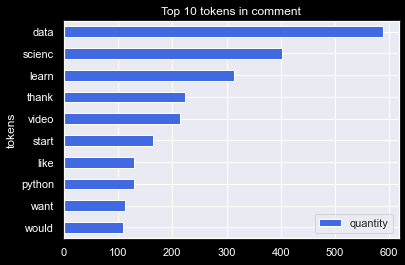

+----+----------+------------+
|    | tokens   |   quantity |
|----+----------+------------|
|  7 | data     |        588 |
|  9 | scienc   |        402 |
|  5 | learn    |        314 |
|  8 | thank    |        224 |
|  6 | video    |        214 |
|  4 | start    |        164 |
|  2 | like     |        130 |
|  3 | python   |        129 |
|  1 | want     |        112 |
|  0 | would    |        109 |
+----+----------+------------+


In [13]:
sample = df["comment"]
Top10_OneSet(sample,"Top 10 tokens in comment"," ", video_id, channel_ID)